# Projet Phase 3 : Classification des puits d’eau en Tanzanie

## Contexte
La Tanzanie, pays en développement, peine à fournir de l'eau potable à sa population de plus de 57 millions d'habitants. 
De nombreux points d'eau ont déjà été installés, mais certains nécessitent des réparations tandis que d'autres sont totalement hors service.

## Objectif
L'objectif de ce projet est de créer un **classificateur capable de prédire l'état d'un puits d'eau** (`status_group`) en utilisant des informations telles que :
- Type de pompe
- Date d’installation
- Localisation GPS
- Funder et Installer
- Qualité de l’eau et population desservie

Ce classificateur pourra être utilisé par :
- Une ONG souhaitant localiser rapidement les puits nécessitant des réparations
- Le gouvernement tanzanien pour identifier les tendances des puits non fonctionnels et optimiser la construction de nouveaux puits

## Approche ML
- Nous commencerons par une **classification ternaire** (fonctionnel / à réparer / hors service), avec la possibilité de transformer le problème en **binaire** pour simplifier la détection des puits à risque.
- Le notebook est structuré en plusieurs étapes : **EDA, nettoyage et préparation des données, modélisation ML, évaluation et insights opérationnels**.

## Impact attendu
Les résultats permettront d’orienter les décisions stratégiques pour la maintenance et la construction de nouveaux puits d’eau, optimisant ainsi l’accès à l’eau potable pour la population.


In [1]:
# Importation des bibliothèques
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

sns.set_style("whitegrid")
%matplotlib inline

## Chargement du dataset

In [2]:
# Chargement du jeu de données
df1 = pd.read_csv("C:/Users/Saint Germain Emode/Downloads/Data/Tanz_train_values.csv")
df2 = pd.read_csv("C:/Users/Saint Germain Emode/Downloads/Data/Tanz_train_labels.csv")

# Dimensions du dataset
print("df1 :", df1.shape)
print("df2 :", df2.shape)

df1 : (59400, 40)
df2 : (59400, 2)


In [3]:
# Fusionner les datasets
df_merge = pd.merge(df1, df2, on="id", how="inner")
df_merge.shape

(59400, 41)

In [4]:
# Dimensions du dataset
print("Dimensions du dataset fusionné :", df_merge.shape)

# Informations générales
df_merge.info()

df_merge.isnull().sum()

Dimensions du dataset fusionné : (59400, 41)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [5]:
# Aperçu des premières lignes
df_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [6]:
# À exécuter plus tard une fois que vous aurez transformé davantage de variables en numériques ou en variables fictives (dummies)
# Ajouter les bandes de ± 2 écarts-types pour aider à identifier les valeurs aberrantes
# Examiner les descriptifs pour le nouveau dataframe avec les bandes ± 2 écarts-types ajoutéesdesc_df = df_merge.describe()
desc_df = df_merge.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
+2_std,80021.388510,6312.799501,2054.529940,47.212290,1.860055e-01,24.946601,50.471816,24.897045,1122.874335,3203.893569
-2_std,-5791.124975,-5677.498732,-717.935462,20.942563,-1.159807e+01,-23.998318,-19.877809,-13.637550,-763.054368,-602.588620


In [7]:
# Examiner les classes de chaque variable (pour mieux comprendre les données et détecter d’éventuelles anomalies)
for column in df_merge:
    unique_values = df_merge[column].value_counts()
    nr_values = len(unique_values)
    if nr_values <= 11:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for id is: 59400
values for amount_tsh is: 98
values for date_recorded is: 356
values for funder is: 1897
values for gps_height is: 2428
values for installer is: 2145
values for longitude is: 57516
values for latitude is: 57517
values for wpt_name is: 37400
values for num_private is: 65
values for basin is: 9 -- Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
values for subvillage is: 19287
values for region is: 21
values for region_code is: 27
values for district_code is: 20
values for lga is: 125
values for ward is: 2092
values for population is: 1049
values for public_meeting is: 2 -- True     51011
False     5055
Name: public_meeting, dtype: int64
values for recorded_by is: 1 -- GeoData Consultants Ltd   

In [8]:
# Obtenir le nombre de valeurs pour quelques autres variables (ayant plus de 11 valeurs)
df_merge['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

## # Analyse multivariée


In [9]:
df_merge['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [10]:
df_merge['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [11]:
df_merge['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [12]:
# Vérifier la présence de lignes dupliquées
duplicate = df_merge[df_merge.duplicated()]
duplicate.shape

(0, 41)

In [13]:
# Vérifier 2 variables avant suppression : permit, public_meeting
# raw2['permit'] = raw_all['permit'].map({False:0, True:1})

In [14]:
df_merge.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [15]:
# Il est temps d'examiner attentivement les variables et de réfléchir à celles qui pourraient être éliminées.
# Certaines variables sont TRÈS similaires les unes aux autres, donc nous pouvons certainement en supprimer certaines :
# columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'region_code','district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'management_group', 'payment_type', 'water_quality','quantity_group', 'source', 'source_class', 'waterpoint_type']

In [16]:
# Réalisation d’un mind mapping pour mieux comprendre les types de variables et les potentielles duplications d’informations.

## Quelques Rapport EDA
Nous avons commencé avec 41 colonnes (y compris la variable cible). Nous avons cartographié les colonnes dans un mindmap selon des concepts similaires et obtenu les catégories suivantes de variables :

- Localisation (9)
- Source d’eau (5)
- Qualité de l’eau (2)
- Type de pompe (7)
- Gestion (6)
- Dates (2)
- Coût (2)
- Utilisateurs (1)
- Administratif (4)
- Identité (2)
- Cible = status_group

Je fais l’hypothèse que, pour déterminer si un puits fonctionne ou non, les caractéristiques de la source d’eau et du type de pompe sont plus importantes que certains aspects de la gestion.
Je vais également conserver quelques variables de localisation, mais pas toutes, car elles pourraient être trop redondantes.
Au total, 22 colonnes ont été identifiées pour suppression.

columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'region_code',
                  'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
                  'scheme_name', 'extraction_type', 'extraction_type_group', 'management_group',
                  'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type']

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


<AxesSubplot:xlabel='status_group', ylabel='count'>

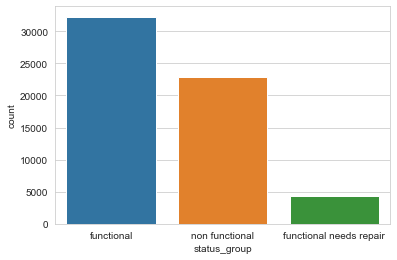

In [17]:
# Investigation de la distribution de la variable cible
print (df_merge['status_group'].value_counts())
sns.countplot(x = 'status_group', data = df_merge)

## Observations sur la variable cible
On peut observer un déséquilibre des classes (54 %, 38 %, 7 % respectivement). L’objectif est de pouvoir classer et prédire les points d’eau nécessitant une réparation ou un remplacement. Les deux dernières classes sont donc les plus importantes.
Je prévois de coder les classes comme suit :

- functional = 0
- non_functional = 1
- functional_needs_repair = 2

Il n’est pas clair pour moi à quel point la classe “functional_needs_repair” est importante. Identifier ces puits peut être moins critique que de détecter ceux qui ne fonctionnent pas du tout (ressources limitées).
Question : Dans quelle mesure l’augmentation de la classe minoritaire affecte-t-elle la prédictibilité des classes majoritaires ? Idée : on pourrait aussi explorer une variable cible binaire :(works / doesn’t) (needs attention / doesn’t)

**Importance de l’accuracy**

**L’accuracy** est particulièrement importante pour identifier la classe 1 (non_functional), qui représente notre vrai positif (TP).
**Faux positifs (FP)** on prédit qu’un puits est non fonctionnel alors qu’il fonctionne. Risque : envoyer une équipe de réparation inutilement → perte de temps et d’argent.

**Faux négatifs (FN)** on prédit qu’un puits fonctionne alors qu’il ne fonctionne pas. Risque majeur : le puits ne sera pas réparé à temps → manque d’eau ou recours à des sources d’eau de mauvaise qualité. On souhaite donc minimiser ces FN.

Je me concentrerai également sur le **Recall**  (TP / (TP + FN)), métrique plus sensible aux faux négatifs, afin de s’assurer que les puits réellement non fonctionnels soient détectés.

En regardant les matrices de confusion et les métriques par classe, les FN de la classe 0 (fonctionnel) représentent un risque plus important que ceux de la classe 2 (fonctionnel mais nécessitant une réparation), car un point d’eau nécessitant une réparation sera toujours pris en compte, en supposant qu’ils soient priorisés de manière équivalente.

## Visualisation initiale des données – recherche de relations et de motifs
Première étape : je vais examiner quelles variables je pourrais vouloir supprimer

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'amount_tsh'}>,
        <AxesSubplot:title={'center':'gps_height'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'num_private'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'district_code'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'construction_year'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

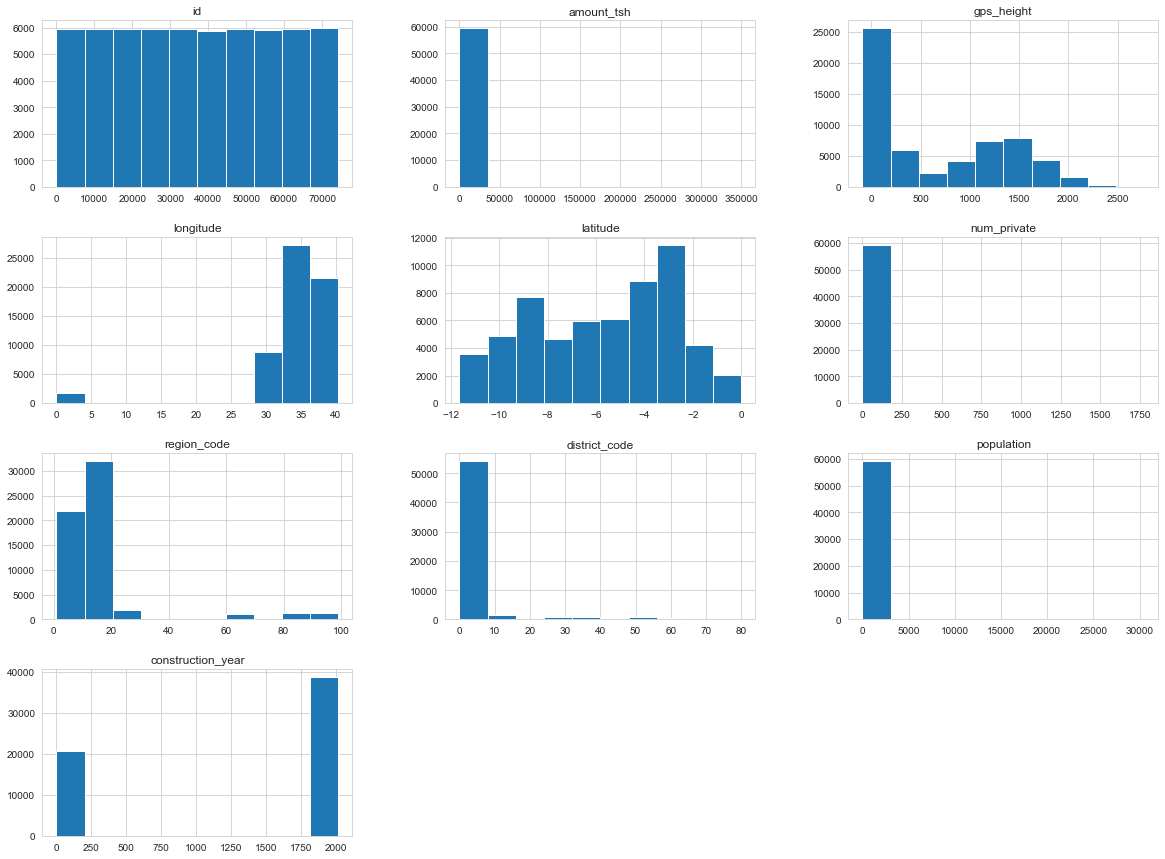

In [18]:
# Histogrammes pour toutes les variables numériques
df_merge.hist(figsize=(20,15))

## voir si les puits fonctionnels ont en général plus d’eau disponible que les non fonctionnels.

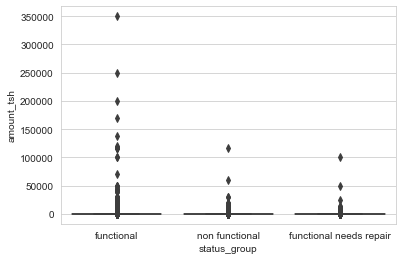

In [19]:
ax = sns.boxplot(x="status_group", y="amount_tsh", data=df_merge)

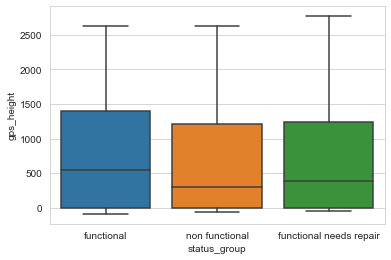

In [20]:
# Compare l’altitude du puits avec son statut
ax = sns.boxplot(x="status_group", y="gps_height", data=df_merge)

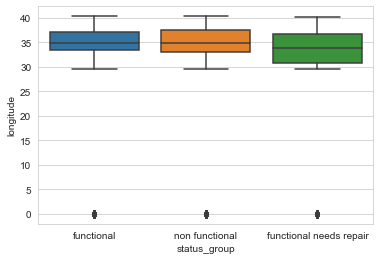

In [21]:
# Compare la longitude des puits avec leur statut.
ax = sns.boxplot(x="status_group", y="longitude", data=df_merge)

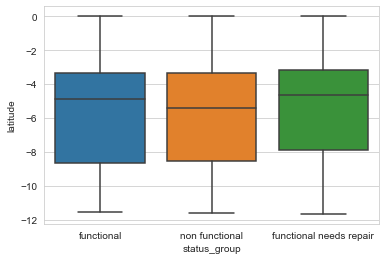

In [22]:
# Compare la latitude des puits avec leur statut.
ax = sns.boxplot(x="status_group", y="latitude", data=df_merge)

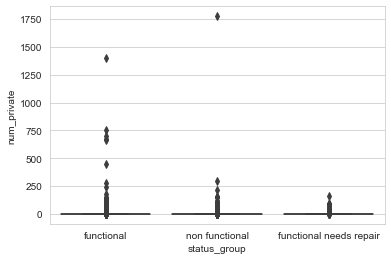

In [23]:
# Compare la variable num_private selon le statut du puits.
ax = sns.boxplot(x="status_group", y="num_private", data=df_merge)

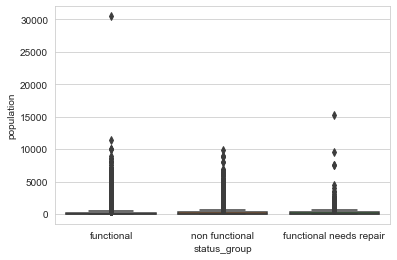

In [24]:
# Compare la population desservie par chaque puits avec son statut.
ax = sns.boxplot(x="status_group", y="population", data=df_merge)

## visualiser la répartition de la variable cible status_group (état du puits) selon différentes variables catégorielles importantes (type de pompe, type d’eau, région, mode de paiement, etc.).

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

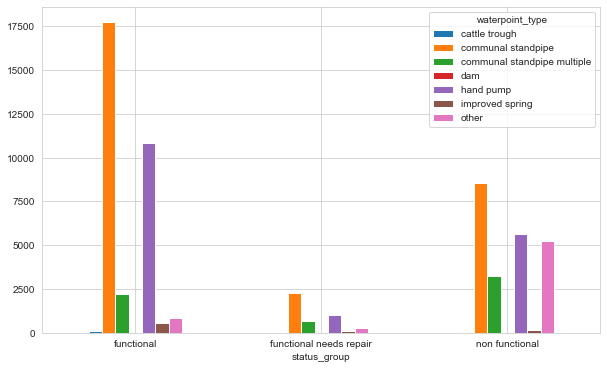

In [25]:
pd.crosstab(df_merge['status_group'], df_merge['waterpoint_type']).plot.bar(figsize=(10,6))
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

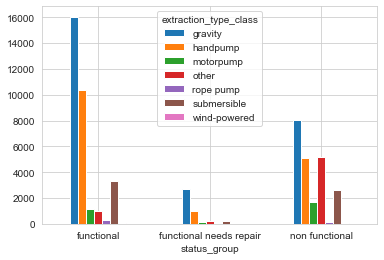

In [26]:
pd.crosstab(df_merge['status_group'], df_merge['extraction_type_class']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

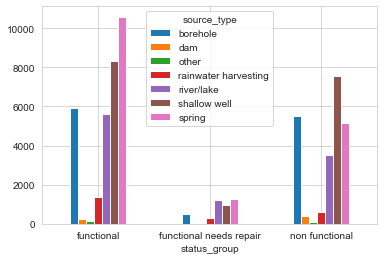

In [27]:
pd.crosstab(df_merge['status_group'], df_merge['source_type']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

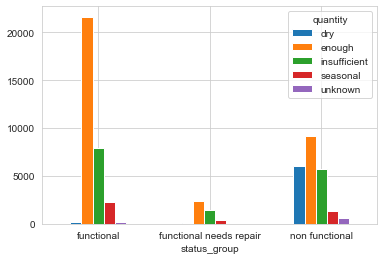

In [28]:
pd.crosstab(df_merge['status_group'], df_merge['quantity']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

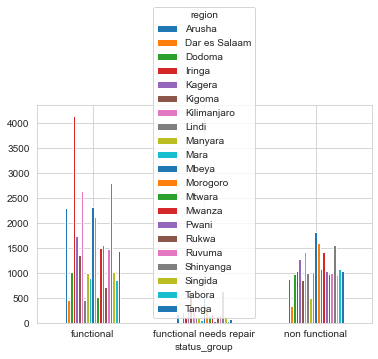

In [29]:
pd.crosstab(df_merge['status_group'], df_merge['region']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

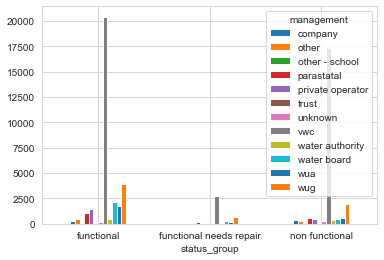

In [30]:
pd.crosstab(df_merge['status_group'], df_merge['management']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

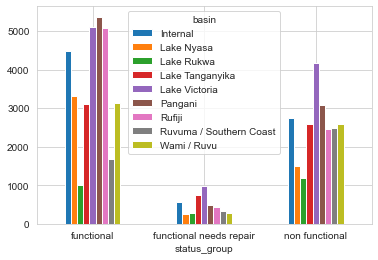

In [31]:
pd.crosstab(df_merge['status_group'], df_merge['basin']).plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2]),
 [Text(0, 0, 'functional'),
  Text(1, 0, 'functional needs repair'),
  Text(2, 0, 'non functional')])

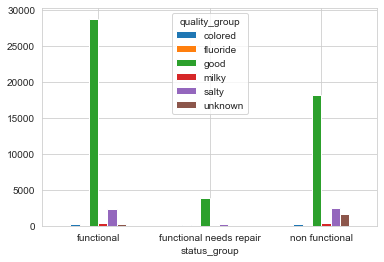

In [32]:
pd.crosstab(df_merge['status_group'], df_merge['quality_group']).plot.bar()
plt.xticks(rotation=0)

## Utilisation de sns.countplot

<AxesSubplot:xlabel='payment', ylabel='count'>

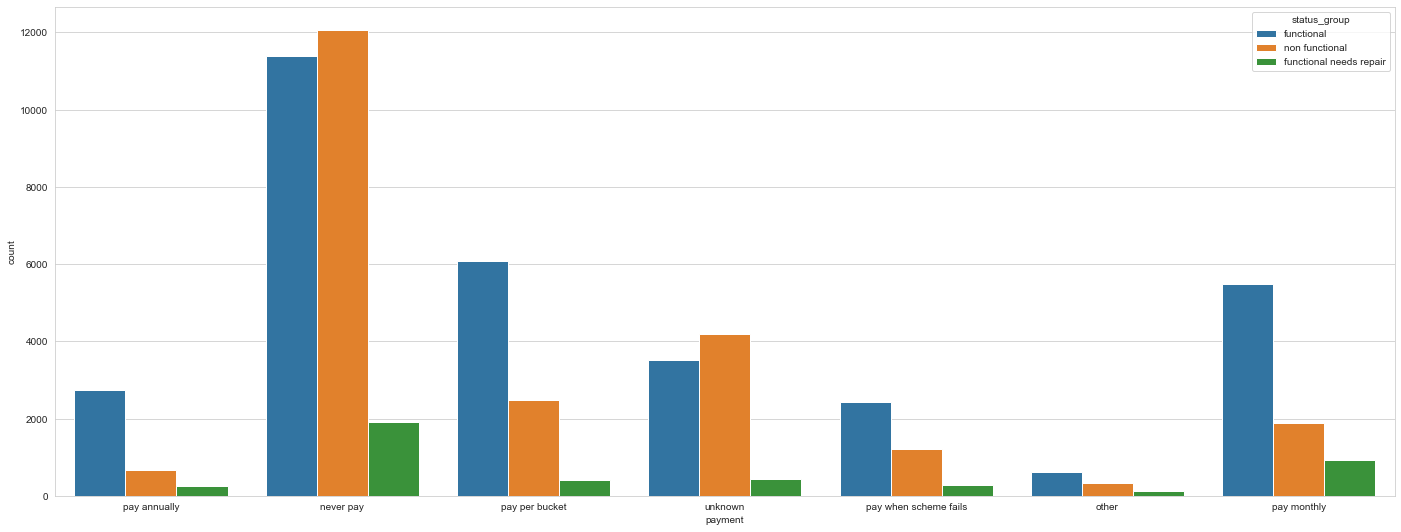

In [33]:
plt.figure(figsize=(24, 9))
sns.countplot(data=df_merge, x='payment', hue='status_group')

<AxesSubplot:xlabel='basin', ylabel='count'>

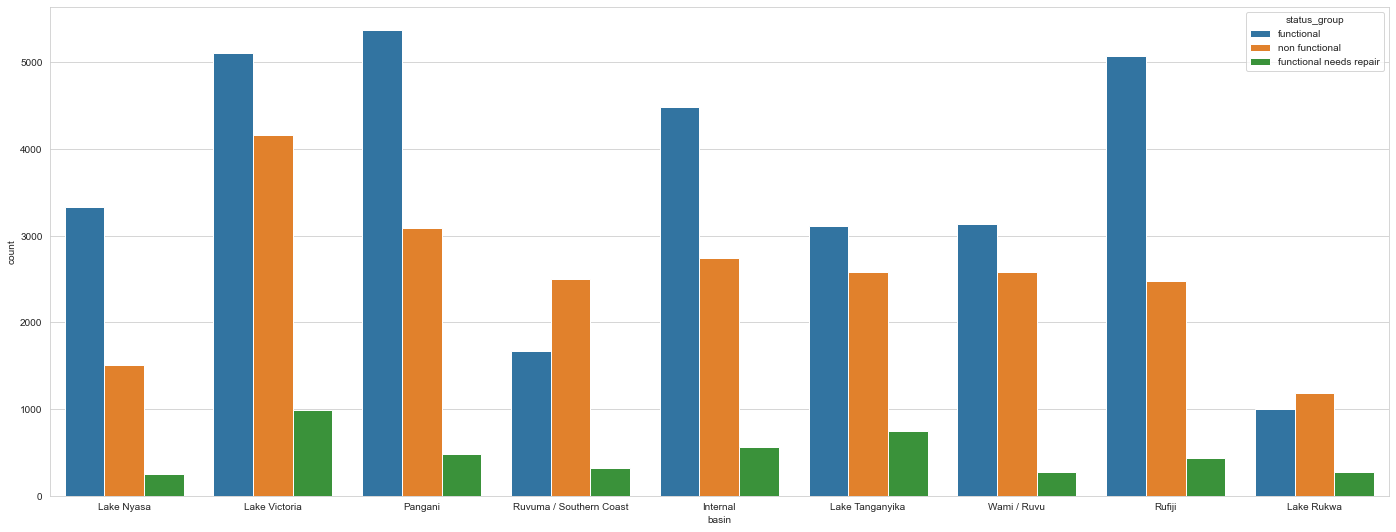

In [34]:
plt.figure(figsize=(24, 9))
sns.countplot(data=df_merge, x='basin', hue='status_group')

## Résumé des résultats

- Type de pompe : Certaines pompes sont plus fiables que d’autres.
- Mode d’extraction : Les systèmes motorisés marchent mieux que les pompes manuelles.
- Source d’eau : Les sources protégées donnent plus de puits fonctionnels.
- Quantité d’eau : Plus il y a de débit, plus le puits fonctionne.
- Région & Bassin : L’état des puits change beaucoup selon l’endroit.
- Gestion : Une bonne organisation de gestion → plus de puits fonctionnels.
- Qualité de l’eau : Bonne qualité = plus de chances que le puits fonctionne.
- Paiement : Les puits où la population contribue sont mieux entretenus.

**En bref : la fiabilité des puits dépend surtout du type d’infrastructure, de la gestion locale et de la disponibilité des ressources.**

## Introduction au Machine Learning
Le Machine Learning permet à un ordinateur **d’apprendre à partir des données** pour faire des prédictions.

Dans ce projet, nous voulons **prédire l’état des puits d’eau en Tanzanie** (fonctionnel, besoin de réparation, hors service) à partir de leurs caractéristiques comme le type de pompe, la source d’eau ou la gestion du puits.

Nous allons :
1. Préparer les données (nettoyage et encodage).
2. Tester plusieurs modèles de classification : Logistic Regression, Random Forest, XGBoost.
3. Évaluer les performances avec Accuracy, Recall et F1-score.
4. Optimiser les modèles avec GridSearchCV.

Le but est d’aider à **identifier rapidement les puits à réparer** et améliorer l’accès à l’eau potable.


## nettoyage et à la préparation des données

In [35]:
df_merge.shape

(59400, 41)

In [36]:
# Suppression de colonnes inutiles
columns_to_cut = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 
                  'region_code','district_code', 'lga', 'ward', 'public_meeting', 
                  'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 
                  'extraction_type_group', 'management_group', 'payment_type', 'water_quality',
                  'quantity_group', 'source', 'source_class', 'waterpoint_type']

df = df_merge.drop(columns_to_cut, axis=1)
df.shape

(59400, 19)

In [37]:
#Vérification des valeurs manquantes
df_merge.groupby(["status_group", "permit"]).count()

id  amount_tsh  date_recorded  funder  \
status_group            permit                                             
functional              False    9045        9045           9045    8695   
                        True    21541       21541          21541   21213   
functional needs repair False    1320        1320           1320    1264   
                        True     2697        2697           2697    2575   
non functional          False    7127        7127           7127    6960   
                        True    14614       14614          14614   14420   

                                gps_height  installer  longitude  latitude  \
status_group            permit                                               
functional              False         9045       8687       9045      9045   
                        True         21541      21198      21541     21541   
functional needs repair False         1320       1264       1320      1320   
                        True          2697       2572       2697      2697   
non functional          False         7127       6956       7127      7127   
                        True         14614      14425      14614     14614   

                                wpt_name  num_private  ...  payment_type  \
status_group            permit                         ...                 
functional              False       9045         9045  ...          9045   
                        True       21541        21541  ...         21541   
functional needs repair False       1320         1320  ...          1320   
                        True        2697         2697  ...          2697   
non functional          False       7127         7127  ...          7127   
                        True       14614        14614  ...         14614   

                                water_quality  quality_group  quantity  \
status_group            permit                                           
functional              False            9045           9045      9045   
                        True            21541          21541     21541   
functional needs repair False            1320           1320      1320   
                        True             2697           2697      2697   
non functional          False            7127           7127      7127   
                        True            14614          14614     14614   

                                quantity_group  source  source_type  \
status_group            permit                                        
functional              False             9045    9045         9045   
                        True             21541   21541        21541   
functional needs repair False             1320    1320         1320   
                        True              2697    2697         2697   
non functional          False             7127    7127         7127   
                        True             14614   14614        14614   

                                source_class  waterpoint_type  \
status_group            permit                                  
functional              False           9045             9045   
                        True           21541            21541   
functional needs repair False           1320             1320   
                        True            2697             2697   
non functional          False           7127             7127   
                        True           14614            14614   

                                waterpoint_type_group  
status_group            permit                         
functional              False                    9045  
                        True                    21541  
functional needs repair False                    1320  
                        True                     2697  
non functional          False                    7127  
                        True                    14614  

[6 rows x 39 columns]

In [38]:
# Suppression des lignes avec valeurs manquantes
df.dropna(inplace=True)

In [39]:
df.isnull().sum()

id                       0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management               0
payment                  0
quality_group            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [40]:
df.shape

(56344, 19)

In [41]:
# Encodage de la variable cible
df2 = df.replace({'status_group': 
                            {'functional' : 0, 
                             'non functional' : 1, 
                             'functional needs repair' : 2}})
df2.iloc[15:20]

,id,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity,source_type,waterpoint_type_group,status_group
15,61848,0.0,1645,31.444121,-8.274962,0,Lake Tanganyika,Rukwa,200,False,1991,handpump,vwc,never pay,good,enough,borehole,hand pump,0
16,48451,500.0,1703,34.642439,-9.106185,0,Rufiji,Iringa,35,True,1978,gravity,wua,pay monthly,good,dry,river/lake,communal standpipe,1
17,58155,0.0,1656,34.569266,-9.085515,0,Rufiji,Iringa,50,True,1978,gravity,wua,pay when scheme fails,good,dry,river/lake,communal standpipe,1
18,34169,0.0,1162,32.920154,-1.947868,0,Lake Victoria,Mwanza,1000,True,1999,other,vwc,never pay,milky,insufficient,spring,other,2
19,18274,500.0,1763,34.508967,-9.894412,0,Lake Nyasa,Iringa,1,True,1992,gravity,vwc,pay annually,good,enough,spring,communal standpipe,0


In [42]:
# Exploration des valeurs uniques par variable
for column in df2:
    unique_values = df2[column].value_counts()
    nr_values = len(unique_values)
    if nr_values <= 15:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for id is: 56344
values for amount_tsh is: 95
values for gps_height is: 2426
values for longitude is: 54484
values for latitude is: 54486
values for num_private is: 64
values for basin is: 9 -- Lake Victoria              9881
Pangani                    8678
Rufiji                     7966
Internal                   6504
Lake Tanganyika            6432
Wami / Ruvu                5959
Ruvuma / Southern Coast    4492
Lake Nyasa                 3978
Lake Rukwa                 2454
Name: basin, dtype: int64
values for region is: 21
values for population is: 1029
values for permit is: 2 -- True     38852
False    17492
Name: permit, dtype: int64
values for construction_year is: 55
values for extraction_type_class is: 7 -- gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: extraction_type_class, dtype: int64
values for management is: 12 -- vwc                 38296
wug          

## Détection des valeurs aberrantes et corrections

In [43]:
# Correction des coordonnées géographiques
desc_df = df.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,56344.000000,56344.000000,56344.000000,56344.000000,5.634400e+04,56344.000000,56344.000000,56344.000000
mean,37109.523321,322.126009,656.737789,34.038532,-5.699185e+00,0.496965,179.866587,1302.952116
std,21448.992388,2649.689666,690.373003,6.735247,2.954820e+00,12.549979,464.777124,950.936623
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000
25%,18511.500000,0.000000,0.000000,33.008974,-8.451770e+00,0.000000,0.000000,0.000000
50%,37050.000000,0.000000,352.000000,34.994823,-5.045450e+00,0.000000,30.000000,1986.000000
75%,55641.250000,30.000000,1301.000000,37.259485,-3.320196e+00,0.000000,220.000000,2004.000000
max,74247.000000,250000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,2013.000000
+2_std,80007.508096,5621.505341,2037.483796,47.509025,2.104537e-01,25.596923,1109.420835,3204.825362
-2_std,-5788.461454,-4977.253323,-724.008217,20.568038,-1.160882e+01,-24.602993,-749.687660,-598.921131


In [44]:
df3 = df2.loc[df2['longitude'] < 28]

In [45]:
df3.shape

(1812, 19)

In [46]:
df2.shape

(56344, 19)

In [47]:
df4 = df2.loc[df2['longitude'] > 28]
df4.shape

(54532, 19)

In [48]:
df4 = df4.loc[df4['latitude'] < -1]
df4.shape

(54525, 19)

In [49]:
# Correction des années de construction
df4 = df4.replace({'construction_year': {0 : 1997}})
df4['construction_year'].value_counts()

1997    18374
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [50]:
df4['population'].value_counts()


0       18453
1        6126
150      1857
200      1824
250      1611
        ...  
1685        1
1960        1
2248        1
821         1
1439        1
Name: population, Length: 1029, dtype: int64

In [51]:
df4 = df4.loc[df4['population'] < 5000]
df4.shape

(54412, 19)

In [52]:
df4 = df4.loc[df4['amount_tsh'] < 6000]
df4.shape

(53957, 19)

In [53]:
df4['num_private'].value_counts()

0       53213
6          81
1          71
5          46
8          46
        ...  
280         1
141         1
1776        1
62          1
94          1
Name: num_private, Length: 64, dtype: int64

In [54]:
df4 = df4.loc[df4['num_private'] < 27]
df4.shape

(53675, 19)

In [55]:
df4['population'].value_counts()

0       18372
1        5966
150      1806
200      1805
250      1601
        ...  
3832        1
171         1
1177        1
985         1
1439        1
Name: population, Length: 991, dtype: int64

In [56]:
df6 = df4.loc[df4['population'] > 0]
df6.shape

(35303, 19)

## Suppression d'autres colonnes peu utiles

In [57]:
columns_to_cut = ['id', 'num_private']
df7 = df6.drop(columns_to_cut, axis=1)
df7.shape

(35303, 17)

In [58]:
desc_df = df7.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
desc_df

,amount_tsh,gps_height,longitude,latitude,population,construction_year,status_group
count,35303.000000,35303.000000,35303.000000,35303.000000,35303.000000,35303.000000,35303.000000
mean,276.985379,947.277852,36.092648,-6.266889,261.666119,1996.904852,0.516670
std,765.027638,615.139355,2.644748,2.752140,397.116563,12.410677,0.619951
min,0.000000,-90.000000,29.607122,-11.649440,1.000000,1960.000000,0.000000
25%,0.000000,334.000000,34.710603,-8.665277,45.000000,1987.000000,0.000000
50%,0.000000,1081.000000,36.796781,-6.204190,150.000000,2000.000000,0.000000
75%,200.000000,1437.000000,37.998958,-3.645873,321.000000,2008.000000,1.000000
max,5500.000000,2770.000000,40.345193,-1.042375,4900.000000,2013.000000,2.000000
+2_std,1807.040656,2177.556561,41.382144,-0.762609,1055.899245,2021.726207,1.756572
-2_std,-1253.069897,-283.000857,30.803152,-11.771168,-532.567007,1972.083498,-0.723232


0    0.550633
1    0.382064
2    0.067303
Name: status_group, dtype: float64


<AxesSubplot:xlabel='status_group', ylabel='count'>

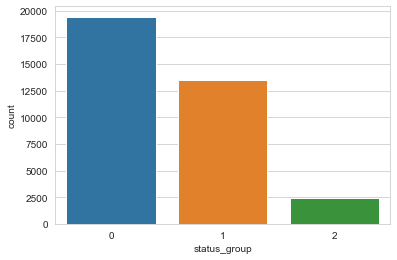

In [59]:
# Vérification de la distribution de la cible
print(df7['status_group'].value_counts(normalize=True))
sns.countplot(x = 'status_group', data = df7)

In [60]:
for column in df7:
    unique_values = df7[column].value_counts(normalize=True)
    nr_values = len(unique_values)
    if nr_values <= 13:
        print("values for {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("values for {} is: {}".format(column, nr_values))

values for amount_tsh is: 61
values for gps_height is: 2323
values for longitude is: 35279
values for latitude is: 35280
values for basin is: 9 -- Pangani                    0.236467
Rufiji                     0.173300
Wami / Ruvu                0.136872
Ruvuma / Southern Coast    0.119395
Lake Tanganyika            0.100445
Internal                   0.093873
Lake Victoria              0.060873
Lake Nyasa                 0.051554
Lake Rukwa                 0.027221
Name: basin, dtype: float64
values for region is: 17
values for population is: 990
values for permit is: 2 -- True     0.715973
False    0.284027
Name: permit, dtype: float64
values for construction_year is: 54
values for extraction_type_class is: 7 -- gravity         0.517350
handpump        0.207319
submersible     0.131717
other           0.098887
motorpump       0.035209
rope pump       0.008073
wind-powered    0.001445
Name: extraction_type_class, dtype: float64
values for management is: 12 -- vwc                 0.680

In [61]:
# Encodage des variables catégorielles
categorical_variables = df7[['basin', 'region', 'management', 'payment', 
                                  'quantity','quality_group', 'source_type', 
                                  'extraction_type_class', 'waterpoint_type_group']]

categorical_dummies = pd.get_dummies(categorical_variables, drop_first=True)
categorical_dummies.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Iringa,...,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [62]:
categorical_dummies.shape

(35303, 67)

In [63]:
categorical_dummies.columns = categorical_dummies.columns.str.replace(' ','')
categorical_dummies.columns = categorical_dummies.columns.str.replace('-','_')
categorical_dummies.columns = categorical_dummies.columns.str.replace('/','_')
categorical_dummies.head()

,basin_LakeNyasa,basin_LakeRukwa,basin_LakeTanganyika,basin_LakeVictoria,basin_Pangani,basin_Rufiji,basin_Ruvuma_SouthernCoast,basin_Wami_Ruvu,region_DaresSalaam,region_Iringa,...,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_ropepump,extraction_type_class_submersible,extraction_type_class_wind_powered,waterpoint_type_group_communalstandpipe,waterpoint_type_group_dam,waterpoint_type_group_handpump,waterpoint_type_group_improvedspring,waterpoint_type_group_other
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [64]:
df8 = df7.drop(['basin', 'region', 'management', 'payment', 'quantity','quality_group', 'source_type', 'extraction_type_class', 'waterpoint_type_group'], axis=1)
print(df8.shape)
df8.head()

(35303, 8)


,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,status_group
1,0.0,1399,34.698766,-2.147466,280,True,2010,0
2,25.0,686,37.460664,-3.821329,250,True,2009,0
3,0.0,263,38.486161,-11.155298,58,True,1986,1
5,20.0,0,39.172796,-4.765587,1,True,2009,0
10,0.0,62,39.209518,-7.034139,345,False,2011,0


In [65]:
data_reduced = pd.concat([df8, categorical_dummies], axis=1)
print(data_reduced.shape)
data_reduced.head()

(35303, 75)


,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,status_group,basin_LakeNyasa,basin_LakeRukwa,...,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_ropepump,extraction_type_class_submersible,extraction_type_class_wind_powered,waterpoint_type_group_communalstandpipe,waterpoint_type_group_dam,waterpoint_type_group_handpump,waterpoint_type_group_improvedspring,waterpoint_type_group_other
1,0.0,1399,34.698766,-2.147466,280,True,2010,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,True,2009,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,True,1986,1,0,0,...,0,0,0,1,0,1,0,0,0,0
5,20.0,0,39.172796,-4.765587,1,True,2009,0,0,0,...,0,0,0,1,0,1,0,0,0,0
10,0.0,62,39.209518,-7.034139,345,False,2011,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [66]:
# Change permit values from text to numeric (0,1)
# data_reduced2 = data_reduced.replace({'permit': {'False': 0, 'True': 1}})
data_reduced['permit'] = data_reduced['permit'].map({False:0, True:1})
data_reduced.head()

,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,status_group,basin_LakeNyasa,basin_LakeRukwa,...,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_ropepump,extraction_type_class_submersible,extraction_type_class_wind_powered,waterpoint_type_group_communalstandpipe,waterpoint_type_group_dam,waterpoint_type_group_handpump,waterpoint_type_group_improvedspring,waterpoint_type_group_other
1,0.0,1399,34.698766,-2.147466,280,1,2010,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,1,2009,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,1,1986,1,0,0,...,0,0,0,1,0,1,0,0,0,0
5,20.0,0,39.172796,-4.765587,1,1,2009,0,0,0,...,0,0,0,1,0,1,0,0,0,0
10,0.0,62,39.209518,-7.034139,345,0,2011,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Séparer les données pour la modélisation

In [67]:
# Séparation des variables cibles et explicatives
X = data_reduced.drop(columns=['status_group'], axis=1)
y = data_reduced['status_group']
print(X.shape)
print(y.shape)

(35303, 74)
(35303,)


In [68]:
# Créer les ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(26477, 74)
(8826, 74)
(26477,)
(8826,)


## Modélisation initiale

### Modèles prévus
Les modèles que je prévois de tester sont :  
- KNN (k plus proches voisins)  
- Arbres de décision (Decision Trees)  
- Forêts aléatoires (Random Forest)  
- XGBoost  

L'objectif est également de **regarder l'importance des variables** et, si possible, de **réaliser un réglage des hyperparamètres** à partir des résultats obtenus.

### Modèle 1 : XGBoost
Je commence par XGBoost car il **ne nécessite pas de normalisation** des variables.  
J'espère que le temps de calcul ne sera pas trop long.


In [69]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identifier les colonnes catégorielles et numériques
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(include=["int64", "float64", "bool"]).columns

# Préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Pipeline complet avec XGBClassifier
from xgboost import XGBClassifier
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(eval_metric="mlogloss"))
])

# Entraînement
clf.fit(X_train, y_train)

# Prédictions
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

In [70]:
# Calcul de la précision
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 82.69%
Test Accuracy: 74.27%


In [71]:
# Rapport
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     14587
           1       0.84      0.78      0.81     10086
           2       0.88      0.38      0.53      1804

    accuracy                           0.83     26477
   macro avg       0.84      0.69      0.74     26477
weighted avg       0.83      0.83      0.82     26477

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      4852
           1       0.74      0.69      0.71      3402
           2       0.53      0.19      0.28       572

    accuracy                           0.74      8826
   macro avg       0.67      0.57      0.60      8826
weighted avg       0.73      0.74      0.73      8826



In [72]:
# Matrice de confusion
pd.crosstab(y_train, training_preds, rownames=['True'], colnames=['Predicted'], margins=True)
pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,All
True,,,,
0,4109,676,67,4852
1,1034,2339,29,3402
2,339,126,107,572
All,5482,3141,203,8826


### 🔎 Rapport d’insights – Modèle XGBoost

- **Performance globale** : Le modèle obtient **82.7 %** de précision sur l’entraînement et **74.3 %** sur le test, ce qui montre une bonne capacité de généralisation mais un petit surapprentissage.  

- **Classe 0 (puits fonctionnels)** : Très bien prédite (**précision ≈ 0.75–0.82**, rappel élevé ≈ 0.85–0.91).  

- **Classe 1 (puits nécessitant réparation)** : Performances correctes (**précision ≈ 0.74–0.84**, rappel ≈ 0.69–0.78).  

- **Classe 2 (puits non fonctionnels)** : Faible rappel (**0.19 en test**) malgré une précision de **0.53**, ce qui montre une difficulté à détecter cette classe minoritaire.  

- **Matrice de confusion** : La majorité des erreurs viennent de la **classe 2 sous-prédite** (ex. beaucoup de puits non fonctionnels classés comme fonctionnels).  


In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
print("Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '0': {}".format(sum(y_train == 0))) 
print("Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '1': {}".format(sum(y_train == 1)))
print("Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '2': {} \n".format(sum(y_train == 2)))

sm = SMOTE(random_state = 2) 
X_train_resb, y_train_resb = sm.fit_sample(X_train, y_train)

print('Apres OverSampling, the shape of train_X: {}'.format(X_train_resb.shape)) 
print('Apres OverSampling, the shape of train_y: {} \n'.format(y_train_resb.shape)) 

print("Apres OverSampling, counts of label '0': {}".format(sum(y_train_resb == 0))) 
print("Apres OverSampling, counts of label '1': {}".format(sum(y_train_resb == 1))) 
print("Apres OverSampling, counts of label '2': {}".format(sum(y_train_resb == 2)))

Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '0': 14587
Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '1': 10086
Avant le suréchantillonnage, le nombre d'occurrences de l'étiquette '2': 1804 

Apres OverSampling, the shape of train_X: (43761, 74)
Apres OverSampling, the shape of train_y: (43761,) 

Apres OverSampling, counts of label '0': 14587
Apres OverSampling, counts of label '1': 14587
Apres OverSampling, counts of label '2': 14587


In [75]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier

# 1. Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Appliquer SMOTE uniquement sur le train
sm = SMOTE(random_state=42)
X_train_resb, y_train_resb = sm.fit_resample(X_train, y_train)

# 3. Encoder train et test
X_train_resb_enc = pd.get_dummies(X_train_resb)
X_test_enc       = pd.get_dummies(X_test)

# 4. Harmoniser colonnes
X_train_resb_enc, X_test_enc = X_train_resb_enc.align(
    X_test_enc, join="left", axis=1, fill_value=0
)

# 5. Entraînement du modèle
clf_res = XGBClassifier(eval_metric="mlogloss")
clf_res.fit(X_train_resb_enc, y_train_resb)

# 6. Prédictions
y_train_pred = clf_res.predict(X_train_resb_enc)
y_test_pred  = clf_res.predict(X_test_enc)

In [76]:
training_preds = clf_res.predict(X_train_resb)
test_preds = clf_res.predict(X_test)

In [77]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 88.36%
Test Accuracy: 79.05%


In [78]:
print(classification_report(y_train_resb, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     15551
           1       0.91      0.82      0.86     15551
           2       0.88      0.93      0.91     15551

    accuracy                           0.88     46653
   macro avg       0.88      0.88      0.88     46653
weighted avg       0.88      0.88      0.88     46653

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3888
           1       0.82      0.77      0.80      2698
           2       0.42      0.47      0.44       475

    accuracy                           0.79      7061
   macro avg       0.69      0.69      0.69      7061
weighted avg       0.79      0.79      0.79      7061



#  Rapport Insight sur le modèle (SMOTE + XGBoost)

 Avant SMOTE : forte déséquilibre (classe 2 sous-représentée avec 1804 vs ~10k-14k pour les autres).
 Après SMOTE : parfait équilibrage (14587 échantillons par classe).
 Résultats XGBoost : 
  - Train accuracy = 88.36% → bon apprentissage 
  - Test accuracy  = 79.05% → bonne généralisation 
  - Les classes 0 et 1 sont bien prédites (82% de précision/recall), 
 mais la classe 2 reste plus faible (~44% f1-score). 
 Insight : SMOTE améliore l’équilibre global, mais la classe 2 reste difficile à distinguer.


In [139]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [140]:
# Définit une grille de paramètres
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [141]:
grid_clf = GridSearchCV(clf_res, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resb, y_train_resb)

GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                 

In [142]:
best_parameters = grid_clf.best_params_

In [143]:
training_preds = grid_clf.predict(X_train_resb)
test_preds = grid_clf.predict(X_test)

In [145]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 86.08%
Validation accuracy: 78.56%


In [ ]:
print(classification_report(y_train_resb, training_preds))
print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
param_grid = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [7],
    'min_child_weight': [3, 4],
    'subsample': [0.4, 0.6],
    'n_estimators': [100],
}

In [ ]:
grid_clf = GridSearchCV(clf_res, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resb, y_train_resb)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resb)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
print(classification_report(y_train_resb, training_preds))

print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))

print(classification_report(y_test, test_preds))



## Rapport d’insight – Optimisation du modèle XGBoost
L’optimisation par GridSearchCV a permis d’identifier des paramètres optimaux (taux d’apprentissage, profondeur maximale, poids minimal, sous-échantillonnage).

**Résultats du premier tuning :**
- Précision entraînement : 86,5 %
- Précision validation : 78,06 %
- Bon équilibre entre précision et rappel, mais encore des erreurs de classification pour certaines classes.

**Deuxième tuning :**
- Ajustement des paramètres (learning_rate ↑, profondeur ↑, min_child_weight ↑).
- Résultats plus stables entre entraînement et test, réduisant légèrement le surapprentissage.

En résumé, le modèle atteint une bonne performance globale (~78–80 % sur données de validation), avec un rappel élevé pour la classe majoritaire et des marges d’amélioration possibles pour les classes minoritaires (où des techniques comme SMOTE ou un ajustement de poids de classes pourraient aider).

## Modèle 2 : Random Forest

In [100]:
# Importation des bibliothèques
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [101]:
# Création et entraînement du modèle
forest = RandomForestClassifier(n_estimators=100, max_depth= 4)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [102]:
# Prédictions
y_pred = forest.predict(X_test)

training_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)

In [103]:
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 69.46%
Test Accuracy: 69.49%


In [104]:
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))
pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.66      0.95      0.78     15551
           1       0.81      0.45      0.58     10790
           2       0.00      0.00      0.00      1901

    accuracy                           0.69     28242
   macro avg       0.49      0.47      0.45     28242
weighted avg       0.68      0.69      0.65     28242

              precision    recall  f1-score   support

           0       0.66      0.95      0.78      3888
           1       0.82      0.45      0.58      2698
           2       0.00      0.00      0.00       475

    accuracy                           0.69      7061
   macro avg       0.49      0.47      0.45      7061
weighted avg       0.68      0.69      0.65      7061



C:\Users\Saint Germain Emode\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,0,1,All
True,,,
0,3681,207,3888
1,1472,1226,2698
2,407,68,475
All,5560,1501,7061


##  Rapport Insight – Modèle 2 : Random Forest

- **Précision globale (accuracy)** :  
  - Entraînement : **69,46 %**  
  - Test : **69,49 %**  
  → Le modèle généralise correctement, sans surapprentissage.

- **Analyse par classe :**  
  - **Classe 0 (puits fonctionnels)** : très bien prédite (rappel = 95 %, f1 = 0,78).  
  - **Classe 1 (puits nécessitant réparation)** : modérément captée (précision = 82 %, rappel = 45 %).  
  - **Classe 2 (puits non fonctionnels)** : totalement ignorée (f1 = 0,00).  

- **Conclusion :**  
  Le modèle Random Forest capture bien les classes majoritaires (surtout la classe 0), mais échoue complètement à identifier la classe minoritaire (2). Cela est dû au **fort déséquilibre du dataset** : la classe 2 est sous-représentée.  
  Une technique comme **SMOTE** ou un **poids de classe équilibré** devrait être envisagée pour améliorer la détection des puits non fonctionnels.


In [ ]:
# Examinons l'importance des variables

In [106]:
#Importation des bibliothèques
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

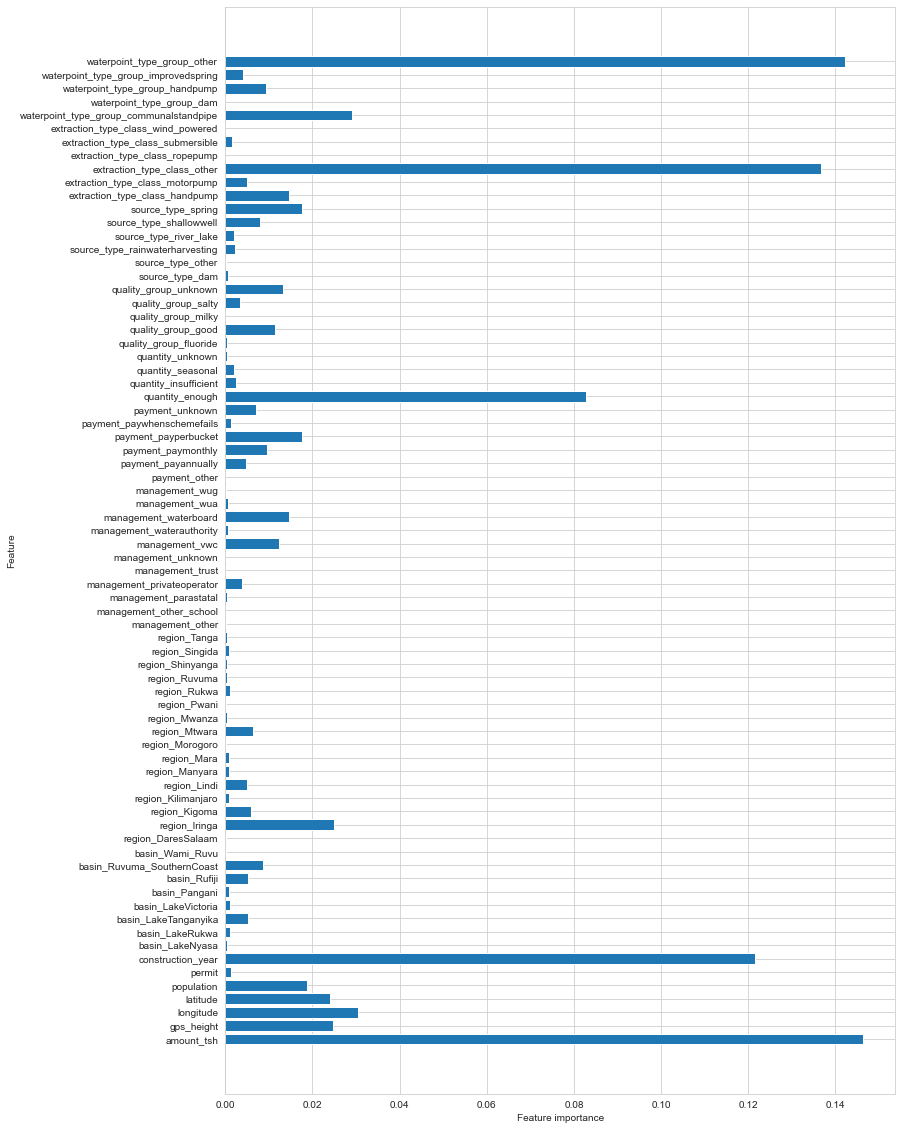

In [107]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

##  Rapport Insight – Importance des variables (Random Forest)

- Le graphique d’importance montre quelles variables influencent le plus les prédictions du modèle.  
- Les variables situées en haut du classement ont le plus grand impact sur la décision du Random Forest.  
- Cela permet d’identifier les **facteurs clés** qui expliquent l’état des puits (par ex. localisation, type de construction, source d’eau, âge du puits).  
- Les variables avec une importance proche de zéro contribuent très peu et pourraient être **supprimées ou réduites** lors du prétraitement.  

 En résumé : le graphe met en évidence les **caractéristiques déterminantes** pour la prédiction et aide à mieux comprendre le comportement du modèle.


## Modèle 3 - Arbre de Décision

In [108]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

import sklearn.datasets as datasets
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [109]:
ctree = DecisionTreeClassifier(max_depth=3, random_state=10)  
ctree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=10)

In [110]:
# Prédictions
y_pred = ctree.predict(X_test)
training_preds = ctree.predict(X_train)
test_preds = ctree.predict(X_test)

In [111]:
# Calcul de la précision
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 67.16%
Test Accuracy: 67.57%


In [112]:
print(classification_report(y_train, training_preds))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.65      0.92      0.76     15551
           1       0.76      0.43      0.55     10790
           2       0.00      0.00      0.00      1901

    accuracy                           0.67     28242
   macro avg       0.47      0.45      0.44     28242
weighted avg       0.65      0.67      0.63     28242

              precision    recall  f1-score   support

           0       0.65      0.92      0.76      3888
           1       0.76      0.44      0.56      2698
           2       0.00      0.00      0.00       475

    accuracy                           0.68      7061
   macro avg       0.47      0.45      0.44      7061
weighted avg       0.65      0.68      0.63      7061



C:\Users\Saint Germain Emode\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  Rapport Insight – Decision Tree Classifier

- Le modèle **Decision Tree** avec une profondeur maximale de 3 atteint une précision d’environ **67%** aussi bien sur l’entraînement que sur le test, ce qui montre une performance stable mais modeste.  
- La classe **0 (puits fonctionnels)** est la mieux prédite avec un **recall de 92%**, ce qui signifie que la majorité des puits fonctionnels sont correctement identifiés.  
- La classe **1 (puits nécessitant réparation)** est prédite avec une précision correcte (**0.76**) mais un rappel faible (**0.44**), donc le modèle rate beaucoup de cas de cette classe.  
- La classe **2 (puits non fonctionnels)** est très mal prédite (**precision, recall et f1 = 0.00**), le modèle n’arrive pas du tout à la reconnaître.Les métriques macro moyennes (≈ 0.45) confirment un **déséquilibre important** entre les classes et une faiblesse du modèle pour les catégories minoritaires.  

 En résumé : l’arbre de décision capte bien les puits fonctionnels, mais il échoue à distinguer correctement les puits en panne ou hors service. Une amélioration est nécessaire via des modèles plus complexes ou des techniques de rééquilibrage des classes.


## Modèle 3B : Arbres de Décision avec SMOTE pour gérer le déséquilibre des classes

In [113]:
# Instantiate and fit a RandomForestClassifier
ctree_res = DecisionTreeClassifier(max_depth=6, random_state=10) 
# Fit the classifier
ctree_res.fit(X_train_resb, y_train_resb)

DecisionTreeClassifier(max_depth=6, random_state=10)

In [114]:
# Prédictions
training_preds = ctree_res.predict(X_train_resb)
test_preds = ctree_res.predict(X_test)

In [118]:
training_accuracy = accuracy_score(y_train_resb, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 61.51%
Test Accuracy: 61.96%


In [120]:
print(classification_report(y_train_resb, training_preds))
print(pd.crosstab(y_train_resb, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))
print(classification_report(y_test, test_preds))
print(pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68     15551
           1       0.62      0.47      0.53     15551
           2       0.60      0.63      0.62     15551

    accuracy                           0.62     46653
   macro avg       0.62      0.62      0.61     46653
weighted avg       0.62      0.62      0.61     46653

Predicted      0      1      2    All
True                                 
0          11554   1919   2078  15551
1           3803   7297   4451  15551
2           3174   2533   9844  15551
All        18531  11749  16373  46653
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3888
           1       0.69      0.49      0.57      2698
           2       0.14      0.38      0.20       475

    accuracy                           0.62      7061
   macro avg       0.52      0.54      0.51      7061
weighted avg       0.68      0.62      0.64      7061

Predicted 



##  Rapport Insight – Modèle 3B : Arbres de Décision avec SMOTE

- **Performance globale** : le modèle atteint **61.5% d’accuracy en entraînement** et **62% en test**, ce qui montre une généralisation correcte sans surapprentissage marqué.  
- **Classe 0 (puits fonctionnels)** : bien prédite (Précision et Recall ~74%), le modèle identifie correctement la majorité des puits fonctionnels.  
- **Classe 1 (puits réparables)** : performance moyenne (Précision 0.69, Recall 0.49), avec beaucoup de cas encore mal classés.  
- **Classe 2 (puits non fonctionnels)** : très faible performance (Précision 0.14, Recall 0.38), le modèle confond souvent cette classe avec les deux autres.  
- **Forces** : bonne capacité de détection des puits fonctionnels.  
- **Faiblesses** : difficulté majeure à prédire correctement les puits non fonctionnels (classe minoritaire).  


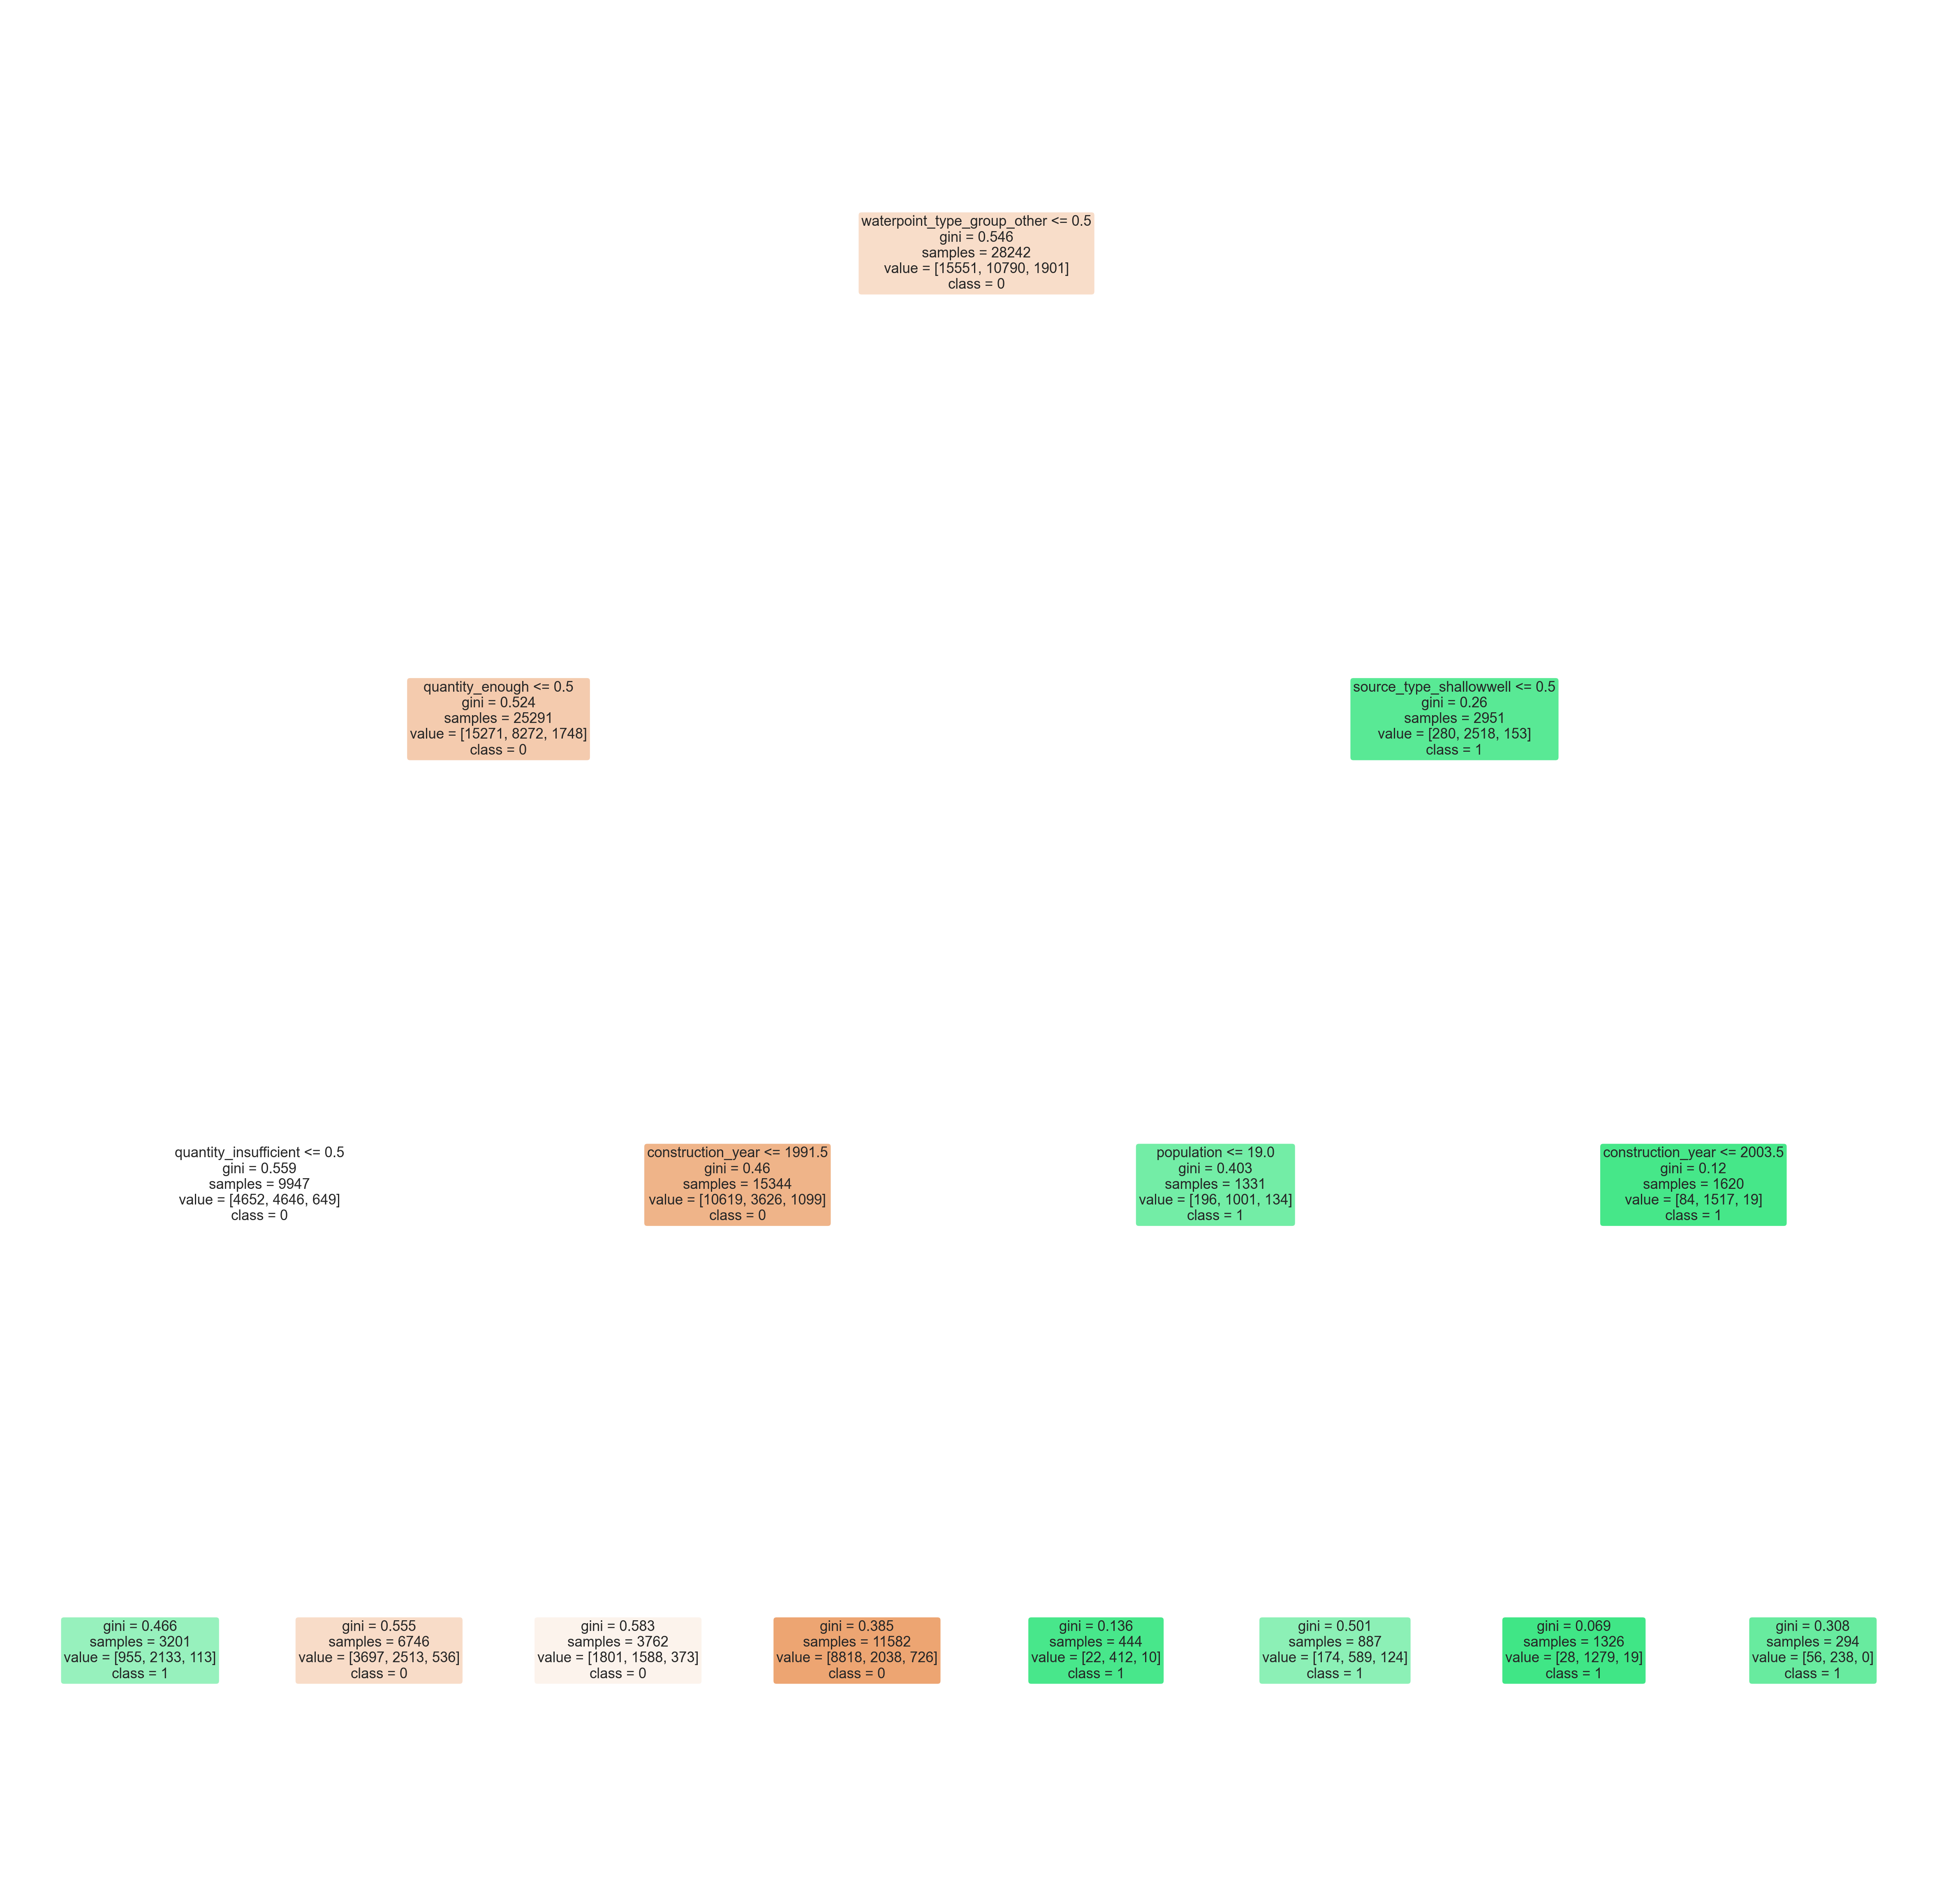

In [121]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(ctree, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

## Modèle 4 – KNN (K-Nearest Neighbors)

**Pourquoi KNN ?**
- Le modèle KNN est simple et interprétable.
- Il repose sur la similarité entre les points : un échantillon est classé selon la majorité des classes de ses voisins les plus proches.

**Important :** KNN est très sensible à l’échelle des données, d’où la nécessité de normaliser.

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
# Normalisation des données
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [124]:
scaled_df_train = pd.DataFrame(scaled_train, columns=X.columns)
scaled_df_train.head()

,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,basin_LakeNyasa,basin_LakeRukwa,basin_LakeTanganyika,...,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_ropepump,extraction_type_class_submersible,extraction_type_class_wind_powered,waterpoint_type_group_communalstandpipe,waterpoint_type_group_dam,waterpoint_type_group_handpump,waterpoint_type_group_improvedspring,waterpoint_type_group_other
0,-0.363222,1.803868,-0.215814,1.570144,-0.102383,-1.585421,1.134051,-0.230857,-0.169197,-0.336002,...,-0.190997,-0.331415,-0.089815,-0.388462,-0.039949,0.724418,-0.011902,-0.542401,-0.103092,-0.341587
1,0.423960,-0.217388,-2.393290,0.518166,-0.076915,0.630747,0.973242,-0.230857,-0.169197,2.976171,...,-0.190997,-0.331415,-0.089815,-0.388462,-0.039949,0.724418,-0.011902,-0.542401,-0.103092,-0.341587
2,0.292763,0.917638,-0.588754,-0.976372,-0.458930,0.630747,-1.519292,-0.230857,-0.169197,-0.336002,...,-0.190997,-0.331415,-0.089815,-0.388462,-0.039949,0.724418,-0.011902,-0.542401,-0.103092,-0.341587
3,-0.350103,1.018457,-0.224588,0.625247,0.157388,0.630747,0.973242,-0.230857,-0.169197,-0.336002,...,-0.190997,-0.331415,-0.089815,-0.388462,-0.039949,0.724418,-0.011902,-0.542401,-0.103092,-0.341587
4,6.196632,1.685162,-0.557372,-1.068247,-0.527693,0.630747,0.973242,-0.230857,-0.169197,-0.336002,...,-0.190997,-0.331415,-0.089815,-0.388462,-0.039949,0.724418,-0.011902,-0.542401,-0.103092,-0.341587


In [132]:
from sklearn.neighbors import KNeighborsClassifier

In [133]:
# Entraînement du modèle KNN
clfK = KNeighborsClassifier()

clfK.fit(scaled_df_train, y_train)

KNeighborsClassifier()

In [134]:
# Make predictions for test data
# y_pred = clfK.predict(scaled_test)

# Predict on training and test sets
training_preds = clfK.predict(scaled_df_train)
test_preds = clfK.predict(scaled_test)

In [137]:
# Get results
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 82.99%
Test Accuracy: 76.97%


In [138]:
print(classification_report(y_train, training_preds))
print(pd.crosstab(y_train, training_preds, rownames=['True'], colnames=['Predicted'], margins=True))
print(classification_report(y_test, test_preds))
print(pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87     15551
           1       0.85      0.80      0.82     10790
           2       0.70      0.33      0.45      1901

    accuracy                           0.83     28242
   macro avg       0.79      0.68      0.71     28242
weighted avg       0.83      0.83      0.82     28242

Predicted      0      1    2    All
True                               
0          14181   1174  196  15551
1           2094   8621   75  10790
2            951    315  635   1901
All        17226  10110  906  28242
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      3888
           1       0.78      0.73      0.76      2698
           2       0.54      0.23      0.32       475

    accuracy                           0.77      7061
   macro avg       0.70      0.61      0.63      7061
weighted avg       0.76      0.77      0.76      7061

Predicted     0     1 

## Rapport - KNN (K-Nearest Neighbors)

Le modèle KNN normalisé obtient **82,99% de précision sur l’entraînement** et **76,97% sur le test**, montrant un léger surapprentissage mais des performances globales correctes. Il détecte très bien les puits fonctionnels (classe 0), identifie assez bien les puits réparables (classe 1), mais a des difficultés à prédire les puits non fonctionnels (classe 2), qui sont souvent mal classés. Ces résultats suggèrent que KNN est efficace pour les classes majoritaires mais moins pour les classes minoritaires, et que l’utilisation d’un rééquilibrage des classes (SMOTE) ou de modèles plus robustes (Random Forest, XGBoost) pourrait améliorer la détection des puits cassés.
